# The 1D Ising model

As an example for a magnetic material we will simulate a 1D chain of spins, the **1D Ising model**. We will use a Markov Chain Monte Carlo approach with Metropolis sampling to simulate configurations of the chain at a temperature $T$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.matplotlib.style.use('ggplot')

import tqdm

rng = np.random.default_rng(seed=20220428)

In [38]:
# loosely based on Computational Modelling Ch 11 (program 11.6)


class SpinChain:
    def __init__(self, N, kT=1.0, p=0.5):
        """Set up 1D chain with N spins, fraction p flipped down"""
        self.N = N
        self.Nspins = self.N
        self.kT = kT
        self.beta = 1/self.kT
        # initialize by flipping a spin to down with probability p
        self.spins = np.where(rng.uniform(size=N) <= p, -1, 1)
        self.E = None
        self.M = None
        
    def energy(self):
        """total energy in units of epsilon"""
        s = self.spins
        E = np.sum(-s[:-1] * s[1:])   # nearest neighbors
        E += - s[-1] * s[0]    # periodic boundary conditions
        return float(E)
    
    def magnetization(self):
        return float(np.sum(self.spins))
    
    def update(self, i):
        """Update of a single spin i with Metropolis criterion"""
        # i = rng.integers(low=0, high=N, dtype=int)

        s = self.spins
        
        accept = False
        dE = 2 * s[i] * (s[i-1] + s[(i+1) % self.N])  # with periodic boundary conditions
        if dE <= 0:
            accept = True
        else:
            p = np.exp(-self.beta * dE)
            accept = (rng.uniform() < p)
            
        if accept:
            s[i] *= -1
        
        return accept

    def _update(self, i, randfloat):
        """Update of a single spin i with Metropolis criterion.
        
        Generate a random float 0 <= x < 1 for Metropolis in advance.
        """
        
        s = self.spins
        
        accept = False
        dE = 2 * s[i] * (s[i-1] + s[(i+1) % self.N])  # with periodic boundary conditions
        if dE <= 0:
            accept = True
        else:
            p = np.exp(-self.beta * dE)
            accept = (randfloat < p)
            
        if accept:
            s[i] *= -1
        
        return accept
    
    def run(self, iterations=1000, verbose=True):
        """Run `iterations` sweeps of updates."""
        energies = []
        magnetizations = []
        n_accept = 0
        for iteration in tqdm.tqdm(range(iterations), disable=not verbose):
            for i, x in zip(rng.integers(low=0, high=self.N, dtype=int, size=self.N),
                            rng.uniform(size=self.N)):
                accept = self._update(i, x)
                n_accept += accept
            energies.append(self.energy())
            magnetizations.append(self.magnetization())
            
        acceptance_ratio = n_accept / (self.N * iterations)
        self.E = np.array(energies)
        self.M = np.array(magnetizations)
        
        return self.E, self.M, acceptance_ratio
    
    def average(self, a, burnin):
        start = int(round(burnin * len(a)))
        return np.average(a[start:])
    
    def E_average(self, burnin=0.1):
        """<E>/N (with initial burnin % removed)"""
        return self.average(self.E, burnin)/self.N
    
    def M_average(self, burnin=0.1):
        """<M>/N (with initial burnin % removed)"""
        return self.average(self.M, burnin)/self.N
    
    def plot(self, burnin=0.1):
        """Plot model.
        
        The 3-panel plot includes
        1. N spins at the last step
        2. mean energy per spin as function of steps
        3. mean magnetization per spin as function of steps
        
        A "burn-in" period (expressed as the total fraction 
        of MC steps, `burnin`) can be discarded for the calculation of 
        the average energy and magnetization to avoid biasing results
        towards the initial state.
        """
        fig, axes = plt.subplots(1, 3, figsize=(10, 3))

        axes[0].set_title(r"$kT/\epsilon =$" f"{self.kT:.1f}")
        axes[0].grid(False)
        axes[0].pcolormesh(self.spins[np.newaxis, :])
        axes[0].yaxis.set_visible(False)
        axes[0].set_aspect(8)

        # collect data after burnin period
        n_total = len(self.E)
        n_start = int(burnin * n_total)
        steps = np.arange(n_total)
        
        axes[1].set_title(r"$\langle E\rangle/N\epsilon =$" f"{self.E_average(burnin=burnin):.3f}")
        axes[1].plot(steps[:n_start], self.E[:n_start]/self.Nspins, color="r", alpha=0.3)
        axes[1].plot(steps[n_start:], self.E[n_start:]/self.Nspins, color="r", alpha=1)
        axes[1].set(xlabel=r"MC step", ylabel=r"$E/N\epsilon$");

        axes[2].set_title(r"$\langle M\rangle/N =$" f"{self.M_average(burnin=burnin):.3f}")
        axes[2].plot(steps[:n_start], self.M[:n_start]/self.Nspins, color="b", alpha=0.3)
        axes[2].plot(steps[n_start:], self.M[n_start:]/self.Nspins, color="b", alpha=1)
        axes[2].set(xlabel=r"MC step", ylabel=r"$M/N$")

        fig.tight_layout()
        
        return fig    

def E_analytical(T):
    return -np.tanh(1/T)

## Behavior of the 1D Ising model

We can explore a spin chain with $N=100$ spins and easily run it for 10,000 iterations, for a total of $100 \times 10,000 = 1 \times 10^6$ MC steps.

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1908.27it/s]


0.755917


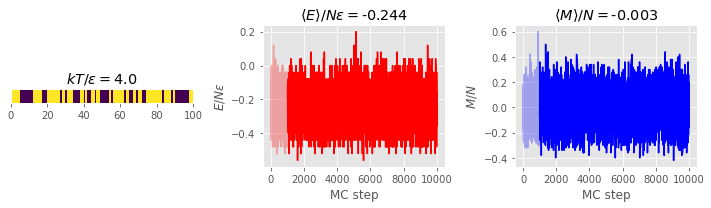

In [47]:
model = SpinChain(100, kT=4,  p=0.5)

E, M, r = model.run(iterations=10000)
print(r)

model.plot();

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1745.02it/s]


0.538744


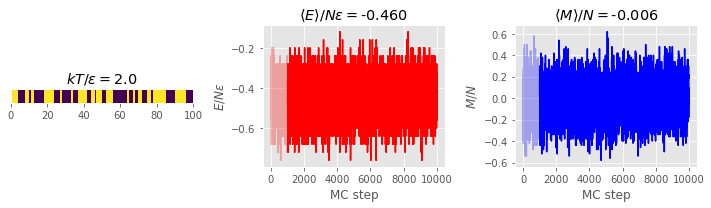

In [46]:
model = SpinChain(100, kT=2,  p=0.5)

E, M, r = model.run(iterations=10000)
print(r)

model.plot();

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1569.11it/s]


0.235734


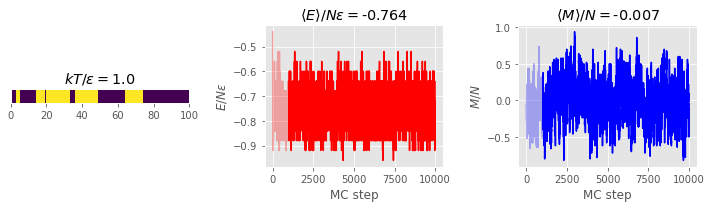

In [45]:
model = SpinChain(100, kT=1,  p=0.5)

E, M, r = model.run(iterations=10000)
print(r)

model.plot();

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1527.06it/s]


0.037907


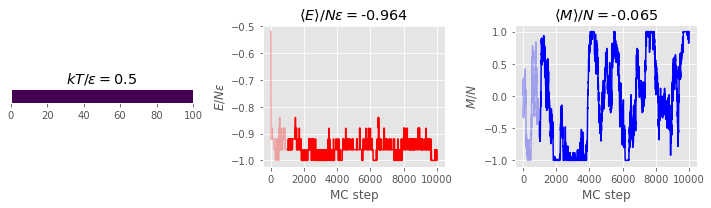

In [48]:
model = SpinChain(100, kT=0.5,  p=0.5)

E, M, r = model.run(iterations=10000)
print(r)

model.plot();

For low temperatures, the acceptance probability is very small so many more iterations are needed to sample the different microstates. Even so, the model does not reach equilibrium because the magnetization remains locked into one state.

100%|█████████████████████████████████| 100000/100000 [01:08<00:00, 1468.57it/s]


0.0001817


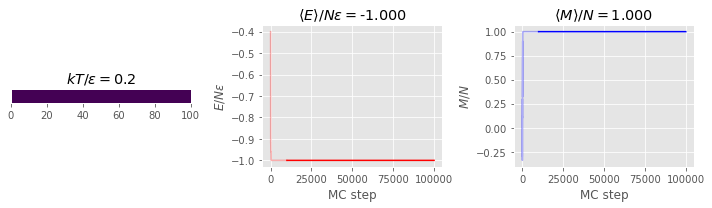

In [51]:
model = SpinChain(100, kT=0.2,  p=0.5)

E, M, r = model.run(iterations=int(1e5))
print(r)

model.plot();

## Temperature dependence of E and M

The dependence of the average energy per spin $\langle E \rangle/N$ on the temperature $T$ for the 1D spin chain is

$$
\frac{\langle E \rangle}{N} = -\epsilon \tanh\frac{\epsilon}{kT}.
$$

The average magnetization per spin $\langle M \rangle/N = 0$ is zero for the 1D chain for all temperatures — the 1D Ising model cannot undergo a phase transition at finite temperature $T > 0$.


Run the simulation for a range of temperatures (measured in $kT$); to run this faster, reduce `iterations` to 1000.

In [52]:
temperatures = np.linspace(0.1, 10, 100)

Nspins = 100
energy = np.zeros_like(temperatures)
magnetization = np.zeros_like(temperatures)

for j, kT in tqdm.tqdm(enumerate(temperatures), total=len(temperatures)):
    model = SpinChain(Nspins, kT=kT)
    model.run(iterations=10000, verbose=False)
    energy[j] = model.E_average()
    magnetization[j] = model.M_average()


100%|█████████████████████████████████████████| 100/100 [08:02<00:00,  4.83s/it]


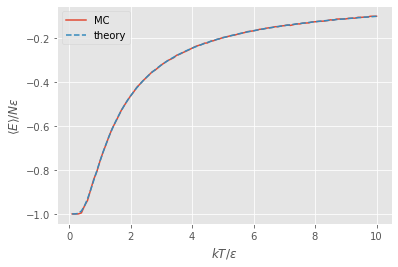

In [53]:
plt.plot(temperatures, energy, label="MC")
plt.plot(temperatures, E_analytical(temperatures), '--', label="theory")
plt.xlabel(r"$kT/\epsilon$")
plt.ylabel(r"$\langle E\rangle/N\epsilon$")
plt.legend()
plt.savefig("ising1d_energy_temperature.png")

The average energy per spin from the simulation matches the theoretical exact result very well.

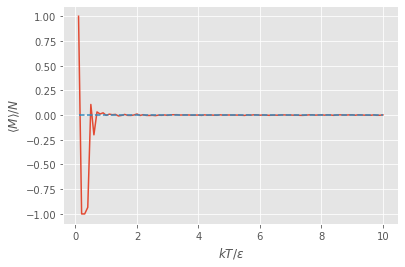

In [54]:
plt.plot(temperatures, magnetization, label="MC")
plt.plot(temperatures, np.zeros_like(temperatures), "--", label="theory")
plt.xlabel(r"$kT/\epsilon$")
plt.ylabel(r"$\langle M \rangle/N$")
plt.savefig("ising1d_magnetization_temperature.png")

The average magnetization should be zero for all sampled temperatures but at low temperatures sampling is very slow and the system does not properly sample from the equilibrium distribution, thus getting stuck in one of the fully magnetized states.